In [19]:
%matplotlib inline
import local_broom

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from qcodes import Station, Instrument
from scipy.signal import find_peaks
from tqdm import tqdm

from monty import Monty
from liveplot import LivePlot, LiveContourPlot
import feedback
import swiper
import MDAC
from fridge import Fridge

# Import the neighbouring files. In may/
import may.dots as dots
from may.custom_devices import connect_to_gb, newSiDot

In [3]:
#%% Connect to instruments

# close any open instruments 
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')
    
try:
    lockin = Instrument.find_instrument("sr860_top")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name sr860_top. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')
lockin = scfg.load_instrument('sr860_top')

# Create our custom MDAC mappings
gb_control_si = connect_to_gb(mdac)
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Attempting to remove instrument with name mdac. Does not exist
Cannot remove instrument with name sr860_top. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.23s
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.12s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [4]:
experiment = {
    "desc": "Recover and find the regime again."
}

monty = Monty("dc.power recovery", experiment)

Started new experiment dc.power_recovery


In [14]:
si.ST()
si.SRB(0.95)
si.SLB(0.95)
si.P1(1.9)
si.P2(1.9)
si.ST(3.3)
si.LCB(0.15)
si.RCB(0.15)

In [109]:
dots.get_all_voltages(mdac)

LCB:   0.150004 V
RCB:   0.150003 V
RG:    0.0 V
ResB:  0.0 V
P3:    0.0 V
P2:    2.099998 V
P1:    1.749996 V
SETB:  0.0 V
SRB:   0.950002 V
SLB:   0.949997 V
ST:    3.242747 V
bias:  0.0 V
VSS1P8:      0.0 V
VSS1P0:      0.0 V
VDD1P8:      1.800005 V
VDD1P0:      0.999996 V
VDD1P8_ANA:  1.8 V
BGN1P0:      0.0 V
BGN1P8:      0.0 V
BGP1P0:      0.0 V
BGP1P8:      0.0 V
RST:         1.799996 V
MOSI:        0.0 V
SCLK:        0.0 V
SS_N:        1.8 V
APBCLK:      0.0 V
VICL:        3.500004 V
VLFG:        0.0 V
VHFG:        0.0 V


## Sweep ST on SET

Started new run 1D_SET_sweep.13
Sweeping Si28_quantum_dot_ST from 3.0V to 3.3V in 201 points.


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [01:17<00:00,  2.59it/s]


Run finished and took 0:01:32.940778.
Saving to 1D_SET_sweep.13.xz
Saving to experiment.yaml


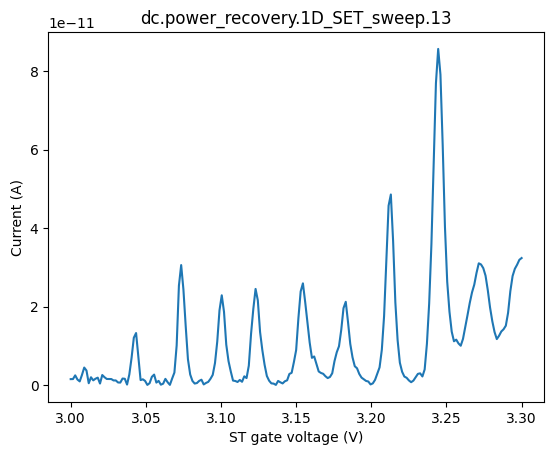

In [98]:
# Get our surroundings

low = 3.0
high = 3.3
pts = 201

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("1D SET sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty)  # overlap points so we average

monty.save(result)

### Proccess SET result
To find a good feedback point

[23 56 86]


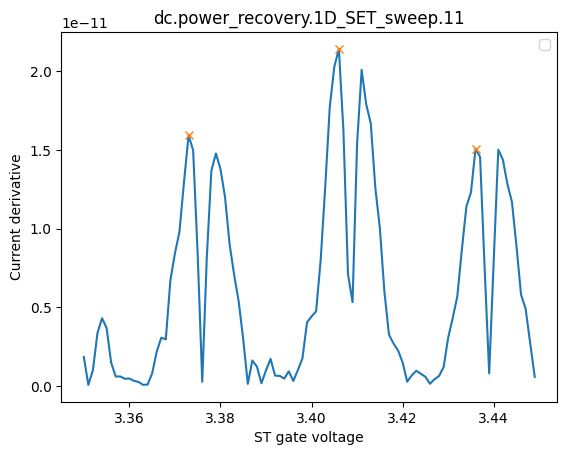

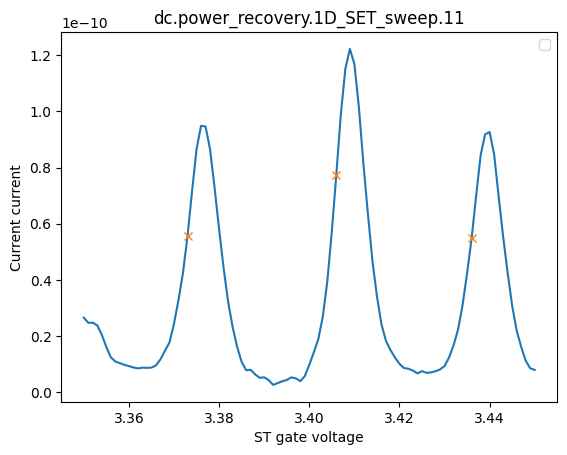

In [67]:
g_range = np.linspace(low, high, pts)
deriv = np.abs(np.diff(result["R"]))
R = result["R"]

peaks, _ = find_peaks(deriv, height=1e-11, distance=20)
#peak = np.argmax(deriv)

fig = plt.figure()
plt.plot(g_range[:-1], deriv)
plt.plot(g_range[peaks], deriv[peaks], "x")
#plt.plot(g_range[peak], deriv[peak], "x")
plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current derivative")
plt.legend()

fig = plt.figure()
plt.plot(g_range, R)
plt.plot(g_range[peaks], R[peaks], "x")
#plt.plot(g_range[peak], deriv[peak], "x")
plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current current")
plt.legend()

print(peaks)

Best peak at inx = 56
Corresponds to ST=3.406 and lockin=7.7549230926e-11


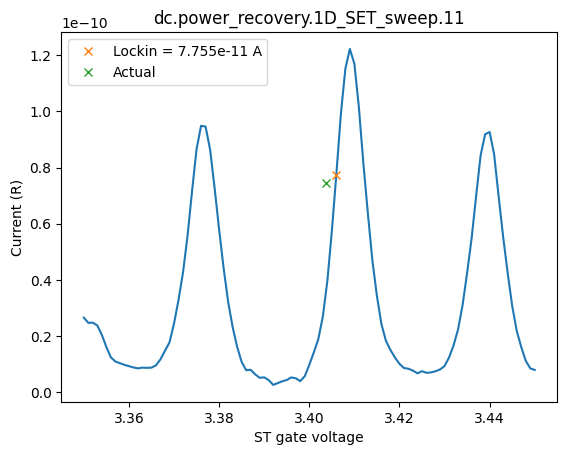

In [72]:
# choose the appropriate peak here
peak = peaks[1]

st_start = g_range[peak]
fix_lockin = result['R'][peak]  # current value to lock in at

print(f"Best peak at inx = {peak}")
print(f"Corresponds to ST={st_start} and lockin={fix_lockin}")

fig = plt.figure()
plt.plot(g_range, result["R"])
plt.plot(g_range[peak], result["R"][peak], "x", label=f"Lockin = {fix_lockin:1.3e} A")

# add where we are now
plt.plot(si.ST(), lockin.R(), "x", label="Actual")

# add our target point
#plt.plot(3.848668, target, "x")

plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current (R)")
plt.legend()

In [101]:
# go to the target
#st_start = 3.24

si.ST(st_start)
time.sleep(1)
lockin.R()

#%% Lock in on target

target = 5e-11  # fix_lockin
tol = 0.001e-10

In [104]:
def feedback(gate, lockin, target: float, stepsize=0.001, slope="up"):
    """
    Apply proportional feedback blindly
    """
    if slope == "up":
        sgn = 1
    elif slope == "down":
        sgn = -1
    else:
        raise (f"Unknown slope '{slope}'. Must be either 'up' or 'down'")

    r = lockin.R()
    error = (target - r) * sgn
    adjust = error / target * stepsize  # normalised error func
    g = gate() + adjust  # new gate voltage

    upperbound = 3.4
    lowerbound = 3.1

    if g > upperbound:  # upper bound
        print(f"Aborting feedback: correction voltage exceeds threshold, {g} > {upperbound}. No change to ST.")
    elif g < lowerbound:  # lower bound
        print(f"Aborting feedback: correction voltage fails to meet threshold, {g} < {lowerbound}. No change to ST.")
    #elif np.abs(r-target) > 0.03e-10:  # take a small step if good
    #    print(f"small step {np.abs(r-target)}")
    #    gate(gate() + adjust/4)
    #    time.sleep(0.5)
    else:
        gate(g)
        time.sleep(0.5)

def gettotarget():  # inherit global variables (bad!!!!)
    print(f"Target = {target:.4e}, tol = {tol}, initial ST = {si.ST()}")
    while np.abs(lockin.R()-target) > tol:
        feedback(si.ST, lockin, target, stepsize=0.001, slope="up")
        print(f"\rST = {si.ST():.4e}, lockin = {lockin.R():.4e}, delta = {np.abs(lockin.R()-target):.4e}", end="")
        time.sleep(0.1)
    print(f"\nFinal ST = {si.ST()}")

In [105]:
gettotarget()

Target = 5.0000e-11, tol = 1e-13, initial ST = 3.239996
ST = 3.2374e+00, lockin = 5.0238e-11, delta = 2.1940e-13
Final ST = 3.237412


## Load/Unload dot methods

In [116]:
# load dots
#dots.loaddots(si, high=1.2)

thresh = 1.15

tic = time.time()
si.SETB(thresh)
time.sleep(0.5)
si.SETB(0)
print(f"Done. Took {time.time()-tic} seconds.")

Done. Took 45.754926681518555 seconds.


In [ ]:
# flush dots 
#dots.flushdots(si, low=1.0, high=1.9)

low = 1.0
high = 1.75

tic = time.time()
si.P1(low)
si.P2(low)
print(f"Flushed out to {low}V, raising to {high}V")
time.sleep(0.5)
si.P1(high)
si.P2(high)
print(f"Done. Took {time.time()-tic} seconds.")

# Sweeps
## P1 scan 1D

In [73]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}")

P1 = 2.1
P2 = 1.900001


In [60]:
si.ST(3.23)  # when doing a downwards sweep slightly undershoot the target point.

Started new run P1_scan.5
Target = 7.7549e-11, tol = 1e-13, initial ST = 3.400949
ST = 3.4008e+00, lockin = 7.6750e-11, delta = 7.5796e-13
Final ST = 3.400792


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [03:49<00:00,  1.14s/it]


Run finished and took 0:03:56.818317.
Saving to P1_scan.5.xz
Saving to experiment.yaml


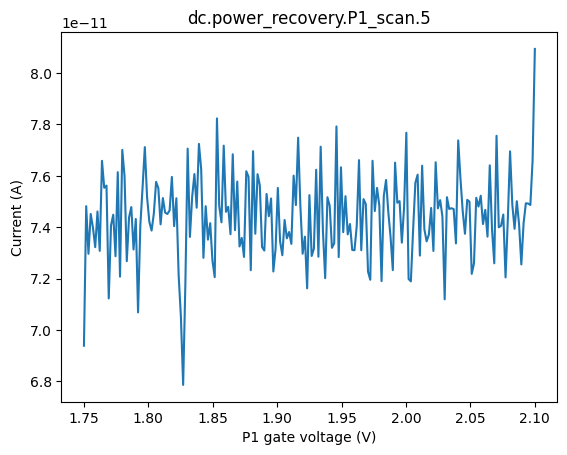

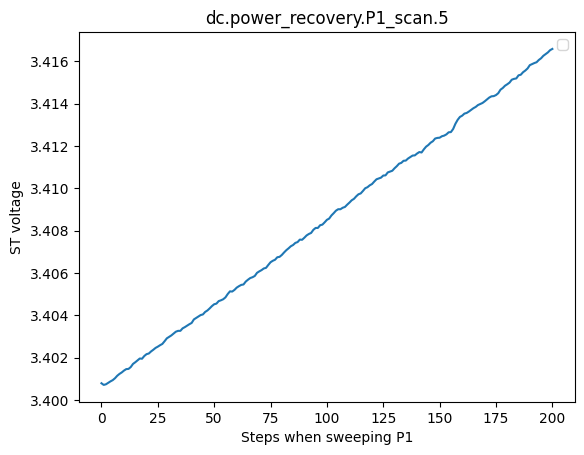

In [76]:
up = False

if up:
    low = 1.75
    high = 2.1
else:
    low = 2.1
    high = 1.75

stepsize = 15e-4
points = 201
gate = si.P1

parameters = {
    "desc": "1D sweep of P1 (with proportional feedback techniques). Stepsize = {stepsize}",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin)",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    "P1": f"Ranged from {low}V -> {high}V in {points} points",
    "P2": f"Fixed at {si.P2()}V",
    "temp": f"Mixing chamber {fridge.temp()} K"
    }

monty.newrun("P1 scan", parameters)

gettotarget()
time.sleep(2)

# don't use swiper to make modifying the feedback easier

gate_range = np.linspace(low, high, points)
X = np.zeros((points))
Y = np.zeros((points))
R = np.zeros((points))
P = np.zeros((points))
ST_drift = np.zeros(points)
delta_I = np.zeros(points)

#fittedfeedback()

# Move to the start and wait a second for the lockin to catchup
# gate(gate_range[0])
# time.sleep(2.0)
# gettotarget()  # get within tolerance now

with tqdm(total=points) as pbar, LivePlot(gate_range, xlabel="P1 gate voltage (V)", ylabel="Current (A)") as lplot:
    for (j, g) in enumerate(gate_range):
        gate(g)
        
        time.sleep(0.5)
        ST_drift[j] = si.ST()
        X[j] = lockin.X()
        Y[j] = lockin.Y()
        R[j] = lockin.R()
        P[j] = lockin.P()
        pbar.update(1)
        lplot.update(R)
        
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
        #delta_I[j] = fittedfeedback()
        
        # time.sleep(0.3)


swiper.plotsweep1d(gate_range, R, gate.name, monty)
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift, 'ST_I': delta_I})

# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
# plt.plot(delta_I)
plt.xlabel("Steps when sweeping P1")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

In [ ]:
# Plot ST history over time
fig = plt.figure()
# plt.plot(ST_drift)
plt.plot(delta_I)
# plt.xlabel("Steps when sweeping P1")
# plt.title(monty.identifier + "." + monty.runname)
# plt.ylabel("ST voltage")
# plt.legend()
# monty.savefig(plt, "ST history")

## Detuning scan

In [119]:
si.P1(1.7)
si.P2(1.9)

In [121]:
si.ST(3.25)
gettotarget()

Target = 5.0000e-11, tol = 1e-13, initial ST = 3.249997
ST = 3.2456e+00, lockin = 5.0282e-11, delta = 2.5692e-13
Final ST = 3.245576


In [ ]:
low = 1.7
high = 1.9
points = 201
stepsize = 20e-4

# choose which gates are going up/down
forward = True
if forward:
    gateup = si.P1
    gatedown = si.P2
else:
    gateup = si.P2
    gatedown = si.P1

parameters = {
    "desc": "Sweep detuning axis (P1 - P2) (no feedback)",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin, stepsize = {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    gateup.name: f"Ranged from {low}V -> {high}V in {points} points",  # P1 or P2
    gatedown.name: f"Ranged from {high}V -> {low}V in {points} points",  # P1 or P2
    "temp": f"Mixing chamber {fridge.temp()} K",
    }

monty.newrun("detuning scan", parameters)

# gate voltage
gate_up_range = np.linspace(low, high, points)
gate_down_range = np.linspace(high, low, points)

# Create detuning axis
detuning = np.linspace(low-high, high-low, points)
if not forward:  # reverse as the data is collected backwards
    detuning = detuning[::-1]

X = np.zeros((points))
Y = np.zeros((points))
R = np.zeros((points))
P = np.zeros((points))
ST_drift = np.zeros(points)
delta_I = np.zeros(points)

#fittedfeedback()
gettotarget()
time.sleep(2)

# Move to the start and wait a second for the lockin to catchup
# gate(gate_range[0])
# time.sleep(2.0)
# gettotarget()  # get within tolerance now

with tqdm(total=points) as pbar, LivePlot(gate_up_range, xlabel="Detuning", ylabel="Current (A)") as lplot:
    for (j, g) in enumerate(gate_up_range):
        gateup(g)
        gatedown(gate_down_range[j])
        time.sleep(0.5)
        
        ST_drift[j] = si.ST()
        X[j] = lockin.X()
        Y[j] = lockin.Y()
        R[j] = lockin.R()
        P[j] = lockin.P()
        
        pbar.update(1)
        lplot.update(R)
        
        #feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
        #delta_I[j] = fittedfeedback()
        # time.sleep(0.3)


#swiper.plotsweep1d(gate_range, R, gate.name, monty)
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}) #, 'ST_I': delta_I})

# Plot detuning
fig = plt.figure()
plt.plot(detuning, R)
plt.xlabel("Detuning (P1 - P2)")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Lockin (A)")
plt.legend()
monty.savefig(plt, "detuning")

# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
plt.xlabel("Detuning step number")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

Started new run detuning_scan.11
Target = 5.0000e-11, tol = 1e-13, initial ST = 3.245576
ST = 3.2456e+00, lockin = 4.9833e-11, delta = 1.7096e-13
Final ST = 3.245566


 33%|███████████████████████████                                                      | 67/201 [00:41<01:22,  1.62it/s]

In [95]:
gb_control_si.VICL()

3.500004

## Charge stability diagram

In [ ]:
# gate 1 stepped over slowly
gate1 = si.P2
low1 = 1.75
high1 = 2.1
points1 = 200

# gate 2 swept frequently
gate2 = si.P1
low2 = 1.75
high2 = 2.1
points2 = 200

stepsize = 12e-4

parameters = {
    "desc": "Sweep both P1 and P2 with feedback present.",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin, stepsize of {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    gate1.name: f"Ranged from {low1}V -> {high1}V in {points1} points",
    gate2.name: f"Ranged from {low2}V -> {high2}V in {points2} points",
    "temp": f"Mixing chamber {fridge.temp()} K",
    }


monty.newrun("p1 vs p2", parameters)

G1_range = np.linspace(low1, high1, points1)
G2_range = np.linspace(low2, high2, points2)

X = np.zeros((points1, points2))
Y = np.zeros((points1, points2))
R = np.zeros((points1, points2))
P = np.zeros((points1, points2))
ST_drift = np.zeros(points1*points2)
delta_I = np.zeros(points1*points2)


with tqdm(total=points1*points2) as pbar, LiveContourPlot(G2_range, G1_range, xlabel=f"{gate2.name} voltage", ylabel=f"{gate1.name} voltage") as lplot:
    for (j, g1) in enumerate(G1_range):
        gate1(g1)
        time.sleep(0.3)
        #gettotarget()
        time.sleep(1)
        
        for (i, g2) in enumerate(G2_range):
            gate2(g2)
            time.sleep(0.3)
            
            ST_drift[j*points2+i] = si.ST()
            X[j, i] = lockin.X()
            Y[j, i] = lockin.Y()
            R[j, i] = lockin.R()
            P[j, i] = lockin.P()
            
            pbar.update(1)
            lplot.update(R)
            
            feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
            #delta_I[j*points2+i] = fittedfeedback()
            
        # Flip the direction of the next sweep
        monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}) #, "ST_T": delta_I})
        G2_range = G2_range[::-1]
        

swiper.plotsweep2d(G1_range, G2_range, R, gate1.name, gate2.name, monty)  # note wont separate directions
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift, "ST_T": delta_I})


# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
plt.xlabel("Steps when sweeping P1/P2")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

# Split the 2D sweep into forwad and backward plots

plt.figure()
plt.pcolormesh(G2_range, G1_range[::2], R[::2, :], shading="nearest")  
plt.colorbar()
plt.ylabel(f"{gate1.name} voltage (V)")
plt.xlabel(f"{gate2.name} voltage (V)")
plt.title(monty.identifier + "." + monty.runname + "_forward")
monty.savefig(plt, "stability forward")

plt.figure()
plt.pcolormesh(G2_range, G1_range[1::2], R[1::2, ::-1], shading="nearest")  
plt.colorbar()
plt.ylabel(f"{gate1.name} voltage (V)")
plt.xlabel(f"{gate2.name} voltage (V)")
plt.title(monty.identifier + "." + monty.runname + "_back")
monty.savefig(plt, "stability backward")

## Detuning scan vs J (2D)

In [ ]:
# Setup P1 / P2  detuning params
lowp = 1.75
highp = 2.1
pointsp = 200

# choose which gates are going up/down
forward = True
if forward:
    gateup = si.P1
    gatedown = si.P2
else:
    gateup = si.P2
    gatedown = si.P1

stepsize = 12e-4

# Setup J1 (VICL) (swept slowly)
lowj = 3.0
highj = 4.0
pointsj = 300
gatej = gb_control_si.VICL

parameters = {
    "desc": "Sweep detuning axis (P1 - P2) against J1 (VICL)",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Start at {si.ST()}V (target of {target} on lockin with stepsize = {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    gateup.name: f"Ranged from {lowp}V -> {highp}V in {pointsp} points",  # P1 or P2
    gatedown.name: f"Ranged from {highp}V -> {lowp}V in {pointsp} points",  # P1 or P2
    "J1": f"Ranged from {lowj}V -> {highj}V in {pointsj} points",
    "temp": f"Mixing chamber {fridge.temp()} K",
    }

gettotarget()
time.sleep(2)

monty.newrun("detuning vs J", parameters)

# gate voltages
gate_up_range = np.linspace(lowp, highp, pointsp)
gate_down_range = np.linspace(highp, lowp, pointsp)
j_range = np.linspace(lowj, highj, pointsj)

# Create detuning axis
mid = (highp-lowp)/2 
detuning = np.linspace(mid-lowp, highp-mid, pointsp)
if not forward:  # reverse as the data is collected backwards (initially)
    detuning = detuning[::-1]

X = np.zeros((pointsj, pointsp))
Y = np.zeros((pointsj, pointsp))
R = np.zeros((pointsj, pointsp))
P = np.zeros((pointsj, pointsp))
ST_drift = np.zeros(pointsj*pointsp)

with tqdm(total=pointsj*pointsp) as pbar, LiveContourPlot(detuning, j_range, xlabel=f"Detuning (P1-P2)", ylabel="J gate voltage") as lplot:
    for (j, gj) in enumerate(j_range):
        gatej(gj)  # J1
        time.sleep(0.3)
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
        #gettotarget()  # perhaps be even more agressive on the start of each sweep?
        time.sleep(1)
        
        for (i, g) in enumerate(gate_up_range):
            gateup(g)
            gatedown(gate_down_range[i])
            time.sleep(0.3)
            
            ST_drift[j*pointsp+i] = si.ST()
            X[j, i] = lockin.X()
            Y[j, i] = lockin.Y()
            R[j, i] = lockin.R()
            P[j, i] = lockin.P()
            
            pbar.update(1)
            lplot.update(R)
            
            feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
            
        monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})
        
        # Flip the direction of the next sweep
        gate_up_range = gate_up_range[::-1]
        gate_down_range = gate_down_range[::-1]

monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}) 


swiper.plotsweep2d(j_range, detuning, R, "J", "Detuning", monty)  # note wont separate directions

# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
plt.xlabel("Steps when sweeping detuning and J1")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

# Split the 2D sweep into forwad and backward plots

plt.figure()
plt.pcolormesh(detuning, j_range[::2], R[::2, :], shading="nearest")  
plt.colorbar()
plt.ylabel("J voltage (V)")
plt.xlabel(f"Detuning voltage(V)")
plt.title(monty.identifier + "." + monty.runname + "_forward")
monty.savefig(plt, "stability forward")

plt.figure()
plt.pcolormesh(detuning, j_range[1::2], R[1::2, ::-1], shading="nearest")  
plt.colorbar()
plt.ylabel("J voltage (V)")
plt.xlabel(f"Detuning voltage (V)")
plt.title(monty.identifier + "." + monty.runname + "_back")
monty.savefig(plt, "stability backward")



